# Instalaçoes e bibliotecas necessárias

In [1]:
!pip install unidecode openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.4 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import re
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Carregando dataset

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideogames_Extension2024.xlsx")
df = df[['TEXTO', 'Polaridad']].dropna()
#alterar dataset:
#df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/MiniProjeto/dataset/CorpusTwitchVideojuegos.xlsx")

# Função de pré-processamento

In [6]:
stop_words = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')
tokenizer = TweetTokenizer()

In [7]:
def preprocess(text):
    text = str(text).lower()
    text = unidecode(text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\b(j[aeiou]{1,})+\b', 'jaja', text)
    text = re.sub(r'\bx[o0]+\b', 'pero', text)
    text = re.sub(r'\bxfa\b', 'por favor', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\b(streamlabs|nightbot)\b', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


# Aplica o pré-processamento

In [8]:
df['clean_text'] = df['TEXTO'].apply(preprocess)

# Vetorização com TF-IDF e preparação de dados


In [9]:
y = df['Polaridad']

In [10]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Validação cruzada

In [12]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definindo modelos

***GRID SEARCH - RANDOM FOREST***

In [13]:
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_features': ['sqrt', 'log2', None]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=cv, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

#PARAMETROS DO ARTIGO: max_features = 'sqrt', n_estimators = 500

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [14]:
print("Melhores parâmetros RF:", rf_grid.best_params_)
rf_model = rf_grid.best_estimator_
rf_pred = rf_model.predict(X_test)

Melhores parâmetros RF: {'max_features': 'log2', 'n_estimators': 500}


***GRID SEARCH - SVM ***

In [15]:
svm_params = {
    'C': [1, 10, 50, 100, 150, 500, 1000],
    'kernel': ['linear', 'rbf', 'poly']
}

svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=cv, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

#PARAMETROS DO ARTIGO: KERNEL RBF, C = 150

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [1, 10, 50, 100, 150, 500, 1000],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy')

In [16]:
print("Melhores parâmetros SVM:", svm_grid.best_params_)
svm_model = svm_grid.best_estimator_
svm_pred = svm_model.predict(X_test)

Melhores parâmetros SVM: {'C': 10, 'kernel': 'rbf'}


# Resultados

***Avalição***

In [17]:
print("\nCLASSIFICAÇÃO RANDOM FOREST")
print(classification_report(y_test, rf_pred))

print("\nCLASSIFICAÇÃO SVM")
print(classification_report(y_test, svm_pred))


CLASSIFICAÇÃO RANDOM FOREST
               precision    recall  f1-score   support

Indeterminado       0.51      0.15      0.23       182
     Negativo       0.61      0.89      0.72       673
     Positivo       0.74      0.50      0.59       525

     accuracy                           0.64      1380
    macro avg       0.62      0.51      0.52      1380
 weighted avg       0.65      0.64      0.61      1380


CLASSIFICAÇÃO SVM
               precision    recall  f1-score   support

Indeterminado       0.46      0.19      0.27       182
     Negativo       0.64      0.87      0.74       673
     Positivo       0.74      0.55      0.63       525

     accuracy                           0.66      1380
    macro avg       0.61      0.54      0.54      1380
 weighted avg       0.65      0.66      0.63      1380



***F1-score - Gráfico***

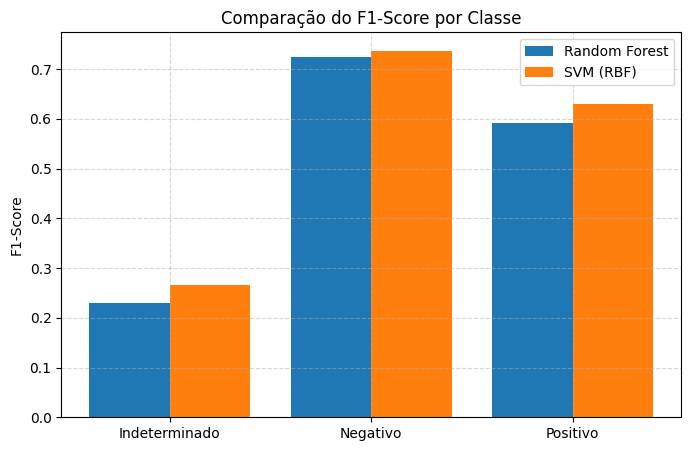

In [18]:
f1_rf = f1_score(y_test, rf_pred, average=None)
f1_svm = f1_score(y_test, svm_pred, average=None)
classes = ['Indeterminado', 'Negativo', 'Positivo']

x = range(len(classes))
plt.figure(figsize=(8, 5))
plt.bar(x, f1_rf, width=0.4, label='Random Forest', align='center')
plt.bar([i + 0.4 for i in x], f1_svm, width=0.4, label='SVM (RBF)', align='center')
plt.xticks([i + 0.2 for i in x], classes)
plt.ylabel('F1-Score')
plt.title('Comparação do F1-Score por Classe')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Matrizes de confusão

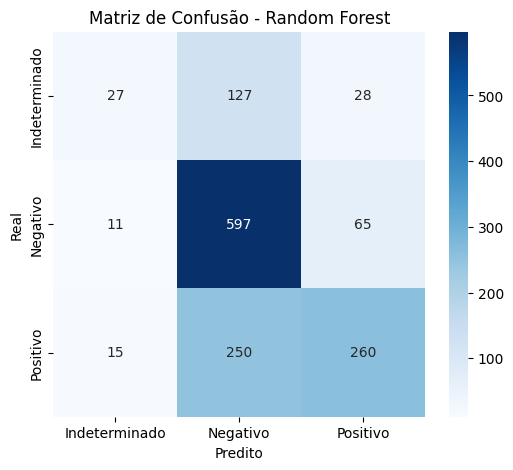

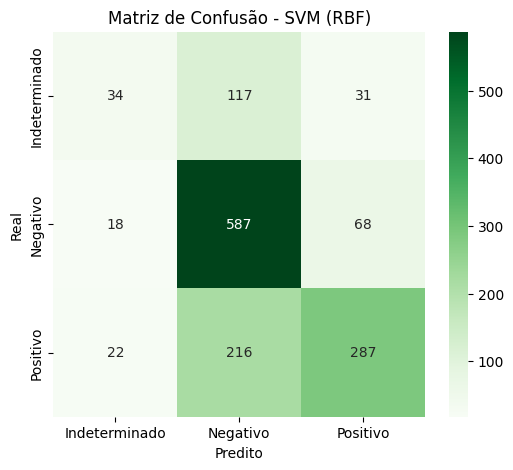

In [19]:
cm_rf = confusion_matrix(y_test, rf_pred, labels=classes)
cm_svm = confusion_matrix(y_test, svm_pred, labels=classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - SVM (RBF)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()